# 3D Convolutional Neural Network for Tomographic Alignment

## Regular CNN Proof of Concept

In order to test potential methods for performing automatic tomographic alignment using neural networks, we start with a standard model using a three dimensional convolution. The main problem with tomographic alignment is that a stack of two dimensional projections have to be processed simultameously for optimal results. While two dimensional convolutions can be used with channels corresponding with each projection angle, this is likely similar in computational complexity to a three dimensional neural network. Therefore the approach for this test is similar to video classification, where each frame in a video is is instead each projection angle. For the purpose of proof of concept only one training entry will be used to make sure that convergence is possible.

In order to test if this method can provide a convergence, phantoms will be artificially misaligned to create a training and testing set. But first packages for tomography, image transformations, and neural networks have to be imported.

In [1]:
# Import essential packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

Since the model will be a computationally complex CNN, we must ensure that the GPU is being used for calculations or else computation will be far too slow.

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


Now that the packages have been imported and CUDA is set up correctly, the next step is to create the dataset to be used for training and testing the neural network. The misalignment function is created to perform different random misalignments on the phantom set of tomographic scans. The shape of all of the data is then checked for errors and the data is split into training and testing sets.

In [3]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    dx = mis_axis[:, 0]
    dy = mis_axis[:, 1]
    prj_tmp = tomopy.shift_images(prj, dx, dy)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()  
            
    return prj_tmp

In [4]:
# Creating ground truth tomography
data = tomopy.shepp3d(256)
ang = tomopy.angles(180)
proj = tomopy.project(data, ang)

In [5]:
# Create dataset to store misaligned projections and 
training_entries = 1
entries = int(np.ceil(training_entries * 5 / 4))
dataset = np.zeros((entries, 2), dtype = object)

for i in range(entries):
    # Randomly determined misalignment axis
    mis_axis = np.random.normal(0, 1, (200, 3))
    mis_axis[:, :1] = mis_axis[:, :1]*4
    mis_axis = np.round(mis_axis).astype(int)
    mis_axis_in = np.expand_dims(mis_axis, axis = 0)
    
    proj_mis = misalign(proj.copy(), mis_axis, ang_tilt = True)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    
    dataset[i, 0] = proj_mis
    dataset[i, 1] = np.concatenate((mis_axis_in[:, :180, 0], mis_axis_in[:, :180, 1]), axis = 1)

In [6]:
print(dataset[0][1])

[[  3   1   3   4  -3  -5   3   6   2   5  -6  -2  -3  -3  -3   6   2  -7
   -2   2  -1   0   0  -4  -2   5   7   7   3   3   6  -4   5  -2  -3  -2
   -4  -8  -7  -7   2  -4  -2  -3  -5  -7   1  -4  -3  -1  -1  -3   1   0
    1   2   3  -1  -2   1   1  -5   4   0   0   6   1   4   0   1  -2   0
    1  -2   5  -5  -1 -12   5  -5  -7  -7  -2  -4   0   2   0  -5   2  -3
    7   3  -5   3   4   4   4  -2   0   6  -1   4  -3  -7   2   7  -1   2
   -8   4   0 -10   4  -5   2   5   0   6   2  -9  -7   5   6   4   8  -5
    6  -5   9   1  -2  -2  -1  -7   2   4  -3  -1  -5   7  -6   6  -5   2
    6  -3  -3  -5   2  -1   0  -3   1   3  -4   4   1   0   6   0   5   1
   -1  -3   0   1  -5   6  -3  -2  -5  -3  -3   2   5   1   1  10   3   3
    2   0   1   1  -1   1   1   0   0   2  -1   1   0   0   2   1   0   1
   -1   0  -1  -2  -1   0  -2   0  -2  -1  -1   0  -3  -1  -1   1   0  -2
    0  -1   1   0   1   0   1   1  -1   0   1   1   0  -2   0   0   2  -1
    2   0  -1   0   0  -3   0  -1   1 

In [7]:
# Checking shape of dataset
print(dataset.shape)
print(dataset[0].shape)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

(2, 2)
(2,)
(1, 1, 180, 256, 366)
(1, 360)


In [8]:
# Checking shape of training and testing splits
trainset, testset = np.split(dataset, [training_entries])
print(trainset.shape)
print(testset.shape)

(1, 2)
(1, 2)


Now that the data has been set up, the CUDA cache should be cleared and the model will be implemented.

In [9]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [10]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

def g_norm(shift):
    mean_tmp = torch.mean(shift)
    std_tmp = torch.std(shift)
    shift = (shift - mean_tmp) / std_tmp
    return shift

# 3D CNN to determine shift parameters

class CNN_3D_aligner(nn.Module):
    def __init__(self):
        super(CNN_3D_aligner, self).__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group5 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group6 = nn.Sequential(
            nn.Conv3d(256, 16, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(16),
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(7040, 512),
            nn.Dropout(0.25),
            nn.Linear(512, 256)
        )
        
        self.fc2 = nn.Linear(256, 360)

    def forward(self, x):
        
        x = norm(x)
        
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        x = self.group6(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In order to ensure the network works and understand its structure before training data on it, use the summary function in order to get an understanding of the network and fix any linear algebra errors in creating the neural network.

In [19]:
# Test model shape
model = CNN_3D_aligner()
summary(model, (1, 1, 180, 256, 366))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3D_aligner                           [1, 360]                  --
├─Sequential: 1-1                        [1, 16, 90, 128, 183]     --
│    └─Conv3d: 2-1                       [1, 16, 180, 256, 366]    448
│    └─BatchNorm3d: 2-2                  [1, 16, 180, 256, 366]    32
│    └─MaxPool3d: 2-3                    [1, 16, 90, 128, 183]     --
├─Sequential: 1-2                        [1, 32, 45, 64, 91]       --
│    └─Conv3d: 2-4                       [1, 32, 90, 128, 183]     13,856
│    └─BatchNorm3d: 2-5                  [1, 32, 90, 128, 183]     64
│    └─MaxPool3d: 2-6                    [1, 32, 45, 64, 91]       --
├─Sequential: 1-3                        [1, 64, 22, 32, 45]       --
│    └─Conv3d: 2-7                       [1, 64, 45, 64, 91]       55,360
│    └─BatchNorm3d: 2-8                  [1, 64, 45, 64, 91]       128
│    └─Conv3d: 2-9                       [1, 64, 45, 64, 91]       110,656


Now the model can be trained, making sure to move all of the elements of the training process to the GPU to optimize computational speed.

In [16]:
# Train the model

# Dataloader for the trainset
# trainload = DataLoader(trainset, batch_size=1, shuffle=True)

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = CNN_3D_aligner()
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 1e-4, momentum=0.9)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 25

# Iniitializing variables to show statistics
iteration = 0
loss_list = []
epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, data in enumerate(trainset, 0):
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Loss: 9.521406173706055 
Epoch: 1   Loss: 9.460906982421875 
Epoch: 2   Loss: 9.373562812805176 
Epoch: 3   Loss: 9.274298667907715 
Epoch: 4   Loss: 9.096601486206055 
Epoch: 5   Loss: 8.983294486999512 
Epoch: 6   Loss: 8.758012771606445 
Epoch: 7   Loss: 8.59803581237793 
Epoch: 8   Loss: 8.523954391479492 
Epoch: 9   Loss: 8.36381721496582 
Epoch: 10   Loss: 8.213109970092773 
Epoch: 11   Loss: 8.228744506835938 
Epoch: 12   Loss: 7.9627814292907715 
Epoch: 13   Loss: 7.882990837097168 
Epoch: 14   Loss: 7.767273902893066 
Epoch: 15   Loss: 7.7261505126953125 
Epoch: 16   Loss: 7.511379718780518 
Epoch: 17   Loss: 7.646814823150635 
Epoch: 18   Loss: 7.543790817260742 
Epoch: 19   Loss: 7.333441257476807 
Epoch: 20   Loss: 7.234949111938477 
Epoch: 21   Loss: 7.1423258781433105 
Epoch: 22   Loss: 7.122256278991699 
Epoch: 23   Loss: 6.93615198135376 
Epoch: 24   Loss: 6.845958232879639 
Epoch: 25   Loss: 6.753934860229492 
Epoch: 26   Loss: 6.6976213455200

Epoch: 215   Loss: 0.32964766025543213 
Epoch: 216   Loss: 0.23457370698451996 
Epoch: 217   Loss: 0.37824547290802 
Epoch: 218   Loss: 0.23913688957691193 
Epoch: 219   Loss: 0.2837229073047638 
Epoch: 220   Loss: 0.2571810483932495 
Epoch: 221   Loss: 0.22633866965770721 
Epoch: 222   Loss: 0.23945003747940063 
Epoch: 223   Loss: 0.24357135593891144 
Epoch: 224   Loss: 0.2936968207359314 
Epoch: 225   Loss: 0.25761741399765015 
Epoch: 226   Loss: 0.3145095407962799 
Epoch: 227   Loss: 0.32247230410575867 
Epoch: 228   Loss: 0.20362576842308044 
Epoch: 229   Loss: 0.21913686394691467 
Epoch: 230   Loss: 0.21545515954494476 
Epoch: 231   Loss: 0.2639792263507843 
Epoch: 232   Loss: 0.20081187784671783 
Epoch: 233   Loss: 0.35185474157333374 
Epoch: 234   Loss: 0.2426292896270752 
Epoch: 235   Loss: 0.2962456941604614 
Epoch: 236   Loss: 0.2263711839914322 
Epoch: 237   Loss: 0.25500282645225525 
Epoch: 238   Loss: 0.2450525164604187 
Epoch: 239   Loss: 0.266925185918808 
Epoch: 240   L

Epoch: 423   Loss: 0.17664270102977753 
Epoch: 424   Loss: 0.18397271633148193 
Epoch: 425   Loss: 0.1458980143070221 
Epoch: 426   Loss: 0.21940210461616516 
Epoch: 427   Loss: 0.20544849336147308 
Epoch: 428   Loss: 0.14247886836528778 
Epoch: 429   Loss: 0.2543484568595886 
Epoch: 430   Loss: 0.16492997109889984 
Epoch: 431   Loss: 0.22773338854312897 
Epoch: 432   Loss: 0.2723974287509918 
Epoch: 433   Loss: 0.23791827261447906 
Epoch: 434   Loss: 0.14506801962852478 
Epoch: 435   Loss: 0.16714194416999817 
Epoch: 436   Loss: 0.16971446573734283 
Epoch: 437   Loss: 0.21472205221652985 
Epoch: 438   Loss: 0.20422708988189697 
Epoch: 439   Loss: 0.23495034873485565 
Epoch: 440   Loss: 0.22413167357444763 
Epoch: 441   Loss: 0.19120946526527405 
Epoch: 442   Loss: 0.17741642892360687 
Epoch: 443   Loss: 0.21797707676887512 
Epoch: 444   Loss: 0.18009068071842194 
Epoch: 445   Loss: 0.19071055948734283 
Epoch: 446   Loss: 0.1541110873222351 
Epoch: 447   Loss: 0.15606415271759033 
Epoc

Epoch: 631   Loss: 0.16621874272823334 
Epoch: 632   Loss: 0.10683422535657883 
Epoch: 633   Loss: 0.1653410643339157 
Epoch: 634   Loss: 0.14600515365600586 
Epoch: 635   Loss: 0.15474623441696167 
Epoch: 636   Loss: 0.0952119529247284 
Epoch: 637   Loss: 0.1314607709646225 
Epoch: 638   Loss: 0.2002263218164444 
Epoch: 639   Loss: 0.16040600836277008 
Epoch: 640   Loss: 0.23097991943359375 
Epoch: 641   Loss: 0.1846572905778885 
Epoch: 642   Loss: 0.20525389909744263 
Epoch: 643   Loss: 0.13697946071624756 
Epoch: 644   Loss: 0.10661551356315613 
Epoch: 645   Loss: 0.18991954624652863 
Epoch: 646   Loss: 0.11620363593101501 
Epoch: 647   Loss: 0.1423344761133194 
Epoch: 648   Loss: 0.12908890843391418 
Epoch: 649   Loss: 0.1685507744550705 
Epoch: 650   Loss: 0.18487335741519928 
Epoch: 651   Loss: 0.21669909358024597 
Epoch: 652   Loss: 0.1515030413866043 
Epoch: 653   Loss: 0.1497531235218048 
Epoch: 654   Loss: 0.12468286603689194 
Epoch: 655   Loss: 0.18613623082637787 
Epoch: 65

Epoch: 839   Loss: 0.13371269404888153 
Epoch: 840   Loss: 0.144126296043396 
Epoch: 841   Loss: 0.17724715173244476 
Epoch: 842   Loss: 0.126384437084198 
Epoch: 843   Loss: 0.14189332723617554 
Epoch: 844   Loss: 0.0866718664765358 
Epoch: 845   Loss: 0.2397988736629486 
Epoch: 846   Loss: 0.14233288168907166 
Epoch: 847   Loss: 0.13363254070281982 
Epoch: 848   Loss: 0.1507112830877304 
Epoch: 849   Loss: 0.12260255962610245 
Epoch: 850   Loss: 0.1196032240986824 
Epoch: 851   Loss: 0.11236792802810669 
Epoch: 852   Loss: 0.13083843886852264 
Epoch: 853   Loss: 0.12200076133012772 
Epoch: 854   Loss: 0.0944480374455452 
Epoch: 855   Loss: 0.1150158941745758 
Epoch: 856   Loss: 0.10782500356435776 
Epoch: 857   Loss: 0.11188478022813797 
Epoch: 858   Loss: 0.11317959427833557 
Epoch: 859   Loss: 0.09298179298639297 
Epoch: 860   Loss: 0.1348383128643036 
Epoch: 861   Loss: 0.1068025603890419 
Epoch: 862   Loss: 0.11428926885128021 
Epoch: 863   Loss: 0.0999351516366005 
Epoch: 864   

Now in order to observe convergence or lack thereof graphs of loss per iteration as well as a moving average based on each epoch are created for analysis.

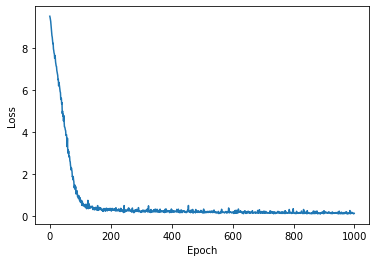

In [17]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As seen above, the neural network is able to create convergence for a mean error of under a pixel, meaning it would be sufficient for tomographic misalignment correction